In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output
from jupyterplot import ProgressPlot

from time import time
from collections import defaultdict

import torch
from torch import nn, optim
import torch.nn.functional as F
import math
import torchvision
from torch.utils.data import DataLoader
from IPython.display import clear_output

import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

/home/volta/Documents/ucph/scientific_programming/3_assignment/acai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = torchvision.datasets.MNIST('/home/volta/Projects/Bakalarka/data',
                                     transform=torchvision.transforms.Compose([
                                         torchvision.transforms.ToTensor(),
                                         torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                                         torchvision.transforms.Lambda(lambda x: torch.flatten(x))])
                                     )

In [3]:
lr = 0.001
activation = nn.ReLU()
latent_width = 10
epochs = 10
#iterations=50
input_size = 28*28

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        
        layers = []
        layers.append(nn.Linear(input_size,500))
        layers.append(nn.ReLU())
        
        layers.append(nn.Linear(500,500))
        layers.append(nn.ReLU())
        
        layers.append(nn.Linear(500,2000))
        layers.append(nn.ReLU())
        
        layers.append(nn.Linear(2000,latent_width))
        #layers.append(nn.ReLU())
        
        self.layer = nn.Sequential(*layers)
        
    def forward (self,x):
        return self.layer(x)
    
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        layers = []
        layers.append(nn.Linear(latent_width,2000))
        layers.append(nn.ReLU())
        
        layers.append(nn.Linear(2000,500))
        layers.append(nn.ReLU())
        
        layers.append(nn.Linear(500,500))
        layers.append(nn.ReLU())
        
        layers.append(nn.Linear(500,input_size))
        
        self.layer = nn.Sequential(*layers)
        
    def forward (self,x):
        return self.layer(x)
    
    
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.encoder = Encoder()
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape(x.shape[0], -1)
        x = torch.mean(x, -1)
        return x

In [5]:
def squared_l2(x):
    return torch.norm(x)**2

In [6]:
def swap(x):
    a, b = x.split(math.ceil(x.shape[0]/2))
    return torch.cat([b, a])

In [7]:
def mean_of_squares ( x ):
    return torch.mean(x**2)

In [8]:
encoder = Encoder().cuda() 
decoder = Decoder().cuda()
critic = Critic().cuda()

ae_optim = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),lr=lr)
critic_optim = torch.optim.Adam(critic.parameters())

In [9]:
test_loader = DataLoader(dataset, batch_size=60000)
for i in test_loader:
    test_x = i[0].to('cuda')
    test_y = i[1]

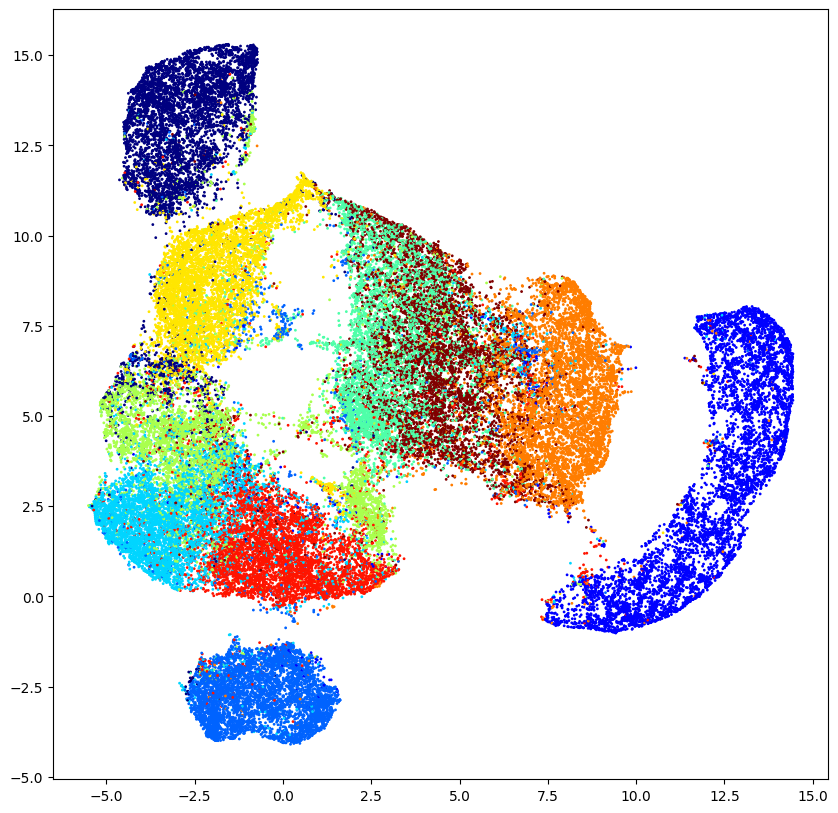

In [ ]:
dataloader = DataLoader(dataset, batch_size=256, num_workers=12)

pp = ProgressPlot(line_names=[ "std of criti", "critic_loss", "ae_loss"])

start = time()

l_param = 0.5
g_param = 0.2

for epoch in range(epochs):
    
    latent = encoder(test_x).cpu().detach().numpy()

    scaled = StandardScaler().fit_transform(latent)
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(scaled)

    figure(figsize=(10,10))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=test_y, s=1, cmap=plt.cm.get_cmap("jet", 10))
    clear_output(wait=True)
    plt.show()    
    print(epoch+1,'/',epochs)
    
    for batch in dataloader:
        
        ae_optim.zero_grad()
        critic_optim.zero_grad()
        
        batch = batch[0].to('cuda')
        
        z1 = encoder(batch)
        ae_out = decoder(z1)
        
        alpha = torch.FloatTensor(batch.shape[0],1).uniform_(0,0.5).to('cuda')
        
        x_alpha = decoder(torch.lerp(swap(z1),z1,alpha))
        
        cr_x_alpha = critic(x_alpha)
        
        ae_loss = F.mse_loss(ae_out, batch) + l_param * mean_of_squares(cr_x_alpha)
        
        critic_loss = F.mse_loss(cr_x_alpha, alpha.reshape(-1)) + mean_of_squares(critic(torch.lerp(ae_out,batch, g_param)))
        
        pp.update([[torch.std(cr_x_alpha).item(),critic_loss,ae_loss]])
                                                                       
        ae_loss.backward(retain_graph=True)
        critic_loss.backward()
        
        ae_optim.step()
        critic_optim.step()        
        
        
end = time()
print(end-start)

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import rand_score

In [ ]:
y_pred = [3, 3, 8, 8]
y_true = [0, 0, 1, 1]

In [ ]:
normalized_mutual_info_score(y_pred, y_true)